In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
import lime.lime_tabular_multiregressor as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
87,6.3,2.3,4.4,1.3,Iris-versicolor
79,5.7,2.6,3.5,1.0,Iris-versicolor
109,7.2,3.6,6.1,2.5,Iris-virginica
23,5.1,3.3,1.7,0.5,Iris-setosa
115,6.4,3.2,5.3,2.3,Iris-virginica
...,...,...,...,...,...
75,6.6,3.0,4.4,1.4,Iris-versicolor
104,6.5,3.0,5.8,2.2,Iris-virginica
54,6.5,2.8,4.6,1.5,Iris-versicolor
59,5.2,2.7,3.9,1.4,Iris-versicolor


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTEMultiRegressionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5,
    discretize_continuous=False,
    use_inversed_data_for_training=True
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

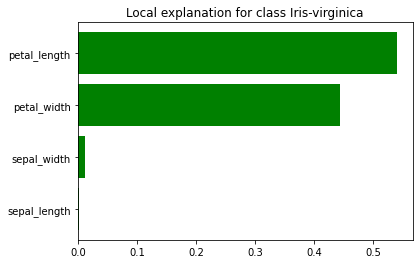

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[0.0, 0.0, 1.0]
[0.0044825292216900785, 0.012395694018213879, 0.9875613410443524]
[0.0044627166, 0.012340905, 0.9831964]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.00127802 0.00626612 0.00366742]
MSE on cv-test  set: [0.00134362 0.00660672 0.00526209]
std on cv-test  set: [9.60521397e-05 6.60473438e-04 1.50046976e-03]


In [11]:
model.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [12]:
import pydotplus
import collections

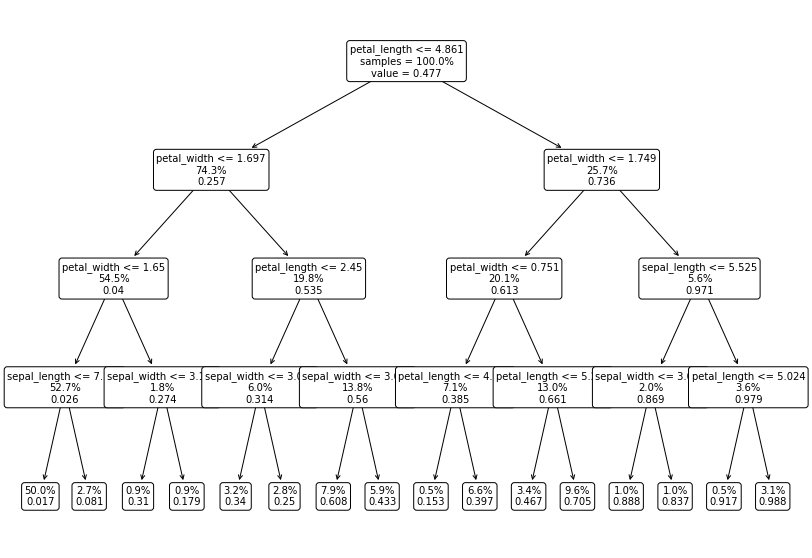

In [13]:
plt.figure(figsize=(14,10))
sklearn.tree.plot_tree(
    explanation.local_surrogates_ensemble[2],
    feature_names=attributes,
    class_names=model.classes_,
    fontsize=10,
    rounded=True,
    label="root",
    impurity=False,
    proportion=True
)
plt.show()

In [14]:
attributes

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [15]:
a = test_x
# a = train_x[[0],:]
a

array([[7.7, 2.6, 6.9, 2.3]])

In [16]:
clf = explanation.local_surrogates_ensemble[2]
dot_data = sklearn.tree.export_graphviz(
    clf,
    feature_names=attributes,
    class_names=model.classes_,
    label="root",
    out_file=None,
    filled=True,
    impurity=False,
    proportion=True,
    rounded=True,
    rotate=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
colors = ('brown', 'forestgreen')
edges = collections.defaultdict(list)

# empty all nodes, i.e.set color to white
for node in graph.get_node_list():
    node.set_fillcolor('white')

decision_path = clf.decision_path(a)
for n, node_value in enumerate(decision_path.toarray()[0]):
    if node_value == 0:
        continue
    node = graph.get_node(str(n))[0]
    node.set_fillcolor('turquoise')

graph.write_png('tree.png')

True

In [17]:
explanation.get_fidelity_loss_on_kfold()

array([0.00322826, 0.00339329, 0.00321066, 0.00329484, 0.00300163])

In [18]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.5402234176277462),
 (3, 0.4450034742561617),
 (1, 0.012347706983978485),
 (0, 0.0024254011321136223)]

In [19]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, 0.5806983137687267),
 (3, 0.40515818418221294),
 (1, 0.013377118997563773),
 (0, 0.0007663830514965023)]

In [20]:
explanation.as_map()

{0: [(3, 0.604562457249134),
  (2, 0.394859283097029),
  (0, 0.0005782596538369139),
  (1, 0.0)],
 1: [(2, 0.5806983137687267),
  (3, 0.40515818418221294),
  (1, 0.013377118997563773),
  (0, 0.0007663830514965023)],
 2: [(2, 0.5402234176277462),
  (3, 0.4450034742561617),
  (1, 0.012347706983978485),
  (0, 0.0024254011321136223)]}

In [21]:
explainer.discretizer.names

AttributeError: 'NoneType' object has no attribute 'names'

In [ ]:
explainer.discretizer.maxs

Update some attributes to see if probabilities would change

In [ ]:
top_features = explanation.as_map()[predicted_label_id]
top_features